In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import aplpy
from astropy.io import fits
from reproject import reproject_interp
from astropy.constants import c, k_B, h

# import molecular_columns as mol_col

from scipy import stats
from config import file_NH3_Tex, file_NH3_eTex, file_NH3_Tkin, file_NH3_eTkin, \
    file_NH3_Ncol, file_NH3_eNcol, file_NH3_Vlsr, file_NH3_eVlsr, \
    file_NH3_dv,  file_NH3_edv

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in'})

In [2]:
file_NH3_TdV = 'data/H-MM1_NH3_11_TdV.fits'
file_NH3_22_TdV = 'data/H-MM1_NH3_22_TdV.fits'
file_H2 = 'data/H-MM1_NH2_6arcsec_aligned.fits'

xpos_lab1, ypos_lab1 = (0.65, 0.915)
xpos_lab2, ypos_lab2 = (0.65, 0.83)
xpos_lab3, ypos_lab3 = (0.075, 0.875)

col_pos = [0.675, 0.7, 0.185, 0.025]

cont_NH3 = np.arange(1.5, 5.1, 0.75)

color_kde = ['#e41a1c', '#377eb8']
color_levels = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c',
                '#fd8d3c', '#fc4e2a', '#e31a1c', '#b10026']
color_levels2 = ['#deebf7', '#c6dbef', '#9ecae1', '#6baed6',
                 '#4292c6', '#2171b5', '#08519c', '#08306b']

In [3]:
sigma_levels = np.array([0.5, 1.0, 1.5, 2.0])
sigma_levels_l = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
filled_levels = np.hstack([0, sigma_levels])  # 9000 sigmas ~ np.inf
filled_levels_l = np.hstack([0, sigma_levels_l])  # 9000 sigmas ~ np.inf
levels_norm = np.exp(-0.5 * sigma_levels ** 2)[::-1]
levels_norm_f = np.exp(-0.5 * filled_levels ** 2)[::-1]
levels_norm_l = np.exp(-0.5 * filled_levels_l ** 2)[::-1]

In [4]:
distance = 145. # pc

def plot_setup_vla(fig_i, label_col='black', do_zoom=True):
    fig_i.set_system_latex(True)
    fig_i.ticks.set_color(label_col)
    fig_i.set_nan_color('0.85')
    if do_zoom:
        fig_i.recenter(246.9954991667, -24.5577775, radius=80*(u.arcsec).to(u.deg))
    fig_i.add_beam(color=label_col)
    ang_size = (3e3 / distance)*u.arcsec
    fig_i.add_scalebar(ang_size, label='3,000 au', color=label_col)
    #
    fig_i.tick_labels.set_xformat('hh:mm:ss')
    fig_i.tick_labels.set_yformat('dd:mm')
    fig_i.ticks.set_length(6)
    fig_i.ax.tick_params(which='minor', length=3)
    fig_i.ticks.set_xspacing(4*15./3600.)
    fig_i.ticks.set_minor_frequency(4)
    #
    fig_i.axis_labels.set_xtext('Right Ascension (J2000)')
    fig_i.axis_labels.set_ytext('Declination (J2000)')
    fig_i.show_contour(file_NH3_TdV, levels=cont_NH3, colors='white', linewidths=1.5)
    fig_i.show_contour(file_NH3_TdV, levels=cont_NH3, colors='black', linewidths=1)
    return fig_i

def hmm1_kde(my_X, my_Y, ymin=0, ymax=2.5, xmin=-0.0002, xmax=0.0008, 
             get_XY=False):
#     ymin=0
#     ymax=2.5
#     xmin=-0.0002
#     xmax=0.0008
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([my_X, my_Y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    if get_XY == False:
        return Z
    else:
        return X, Y, Z

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


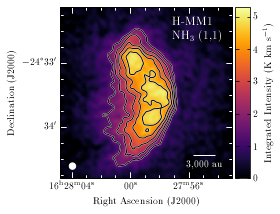

In [5]:
text_color = 'white'
fig = aplpy.FITSFigure(file_NH3_TdV, figsize=(4, 4))
fig.show_colorscale(vmin=0, vmax=5.3, cmap='inferno', interpolation='None')
plot_setup_vla(fig, label_col=text_color)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_colorbar()
# fig_i.colorbar.set_ticks([0,40,80,120,160])
fig.colorbar.set_axis_label_text('Integrated Intensity (K km s$^{-1}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_TdV.pdf', dpi=200)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


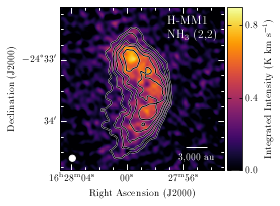

In [6]:
text_color = 'white'
fig = aplpy.FITSFigure(file_NH3_22_TdV, figsize=(4, 4))
fig.show_colorscale(vmin=0, vmax=0.9, cmap='inferno', interpolation='None')
plot_setup_vla(fig, label_col=text_color)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (2,2)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_colorbar()
fig.colorbar.set_ticks([0, 0.4, 0.8])
fig.colorbar.set_axis_label_text('Integrated Intensity (K km s$^{-1}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_22_TdV.pdf', dpi=200)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()
  cm.set_bad(color)


INFO: Auto-setting vmax to  4.764e+00 [aplpy.core]


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


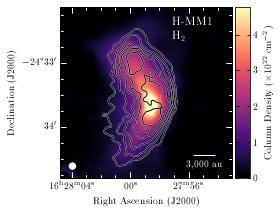

In [7]:
N_H2, hd_H2 = fits.getdata(file_H2, header=True)
hd_H2['BMAJ'] = 6./3600.
hd_H2['BMIN'] = 6./3600.
hd_H2['BPA'] = 0.
hdu_H2 = fits.PrimaryHDU(N_H2/1e22, hd_H2)
text_color = 'white'
fig = aplpy.FITSFigure(hdu_H2, figsize=(4, 4))
fig.show_colorscale(vmin=0, cmap='magma', interpolation='None')
plot_setup_vla(fig, label_col=text_color)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'H$_2$', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_colorbar()
fig.colorbar.set_ticks([0, 1, 2, 3, 4])
fig.colorbar.set_axis_label_text(r'Column Density ($\times$10$^{22}$ cm$^{-2}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_N_H2.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_58822/3463269698.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


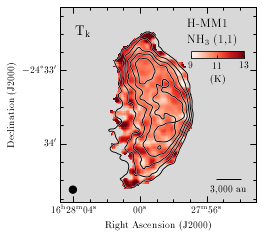

In [8]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_Tkin, figsize=(4, 4))
fig.show_colorscale(vmin=9., vmax=13., cmap='Reds', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'T$_{\rm k}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_ticks([9, 11, 13])
fig.colorbar.set_axis_label_text(r'(K)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Tkin.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues_r").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_58822/1134119013.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


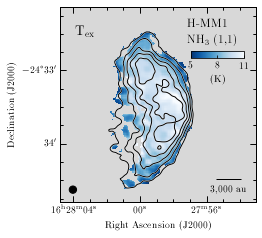

In [9]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_Tex, figsize=(4, 4))
fig.show_colorscale(vmin=5., vmax=11., cmap='Blues_r', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'T$_{\rm ex}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_ticks([5, 8, 11])
fig.colorbar.set_axis_label_text(r'(K)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Tex.pdf', dpi=200)

In [10]:
NH3_Ncol, hd = fits.getdata(file_NH3_Ncol, header=True)
NH3_Ncol_lin = 10**(NH3_Ncol - 14.)
hdu_NH3_Ncol_lin = fits.PrimaryHDU(NH3_Ncol_lin, hd)

hdu_NH3_H2_8 = fits.PrimaryHDU(NH3_Ncol_lin/(N_H2*1e-22), hd)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_58822/1332637765.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


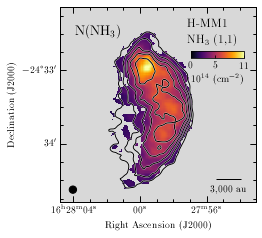

In [11]:
text_color = 'black'

fig = aplpy.FITSFigure(hdu_NH3_Ncol_lin, figsize=(4, 4))
fig.show_colorscale(vmin=0., vmax=11., cmap='inferno', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'N(NH$_{3}$)', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_ticks([0, 5, 11])
fig.colorbar.set_axis_label_text(r'$10^{14}$ (cm$^{-2}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Ncol.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_58822/46978546.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


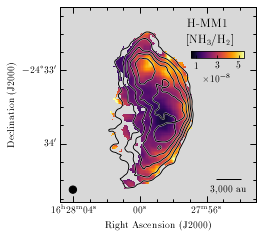

In [12]:
text_color = 'black'
fig = aplpy.FITSFigure(hdu_NH3_H2_8, figsize=(4, 4))
fig.show_colorscale(cmap='inferno', vmin=0.5, vmax=5.5, interpolation='None')
plot_setup_vla(fig, label_col=text_color) #  
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'[NH$_3$/H$_2$]', relative=True, 
                horizontalalignment='left', color=text_color, size=12)

fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_axis_label_text(r'$\times10^{-8}$')
fig.colorbar.set_ticks([1, 3, 5])

plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_H2_ratio.pdf', dpi=200)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


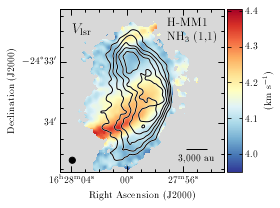

In [13]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_Vlsr, figsize=(4, 4))
fig.show_colorscale(vmin=3.95, vmax=4.405, cmap='RdYlBu_r', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'$V_{\rm lsr}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_ticks([4.0, 4.1, 4.2, 4.3, 4.4])
fig.colorbar.set_axis_label_text(r'(km s$^{-1}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Vlsr.pdf', dpi=100)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greens").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


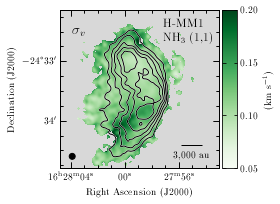

In [14]:
text_color = 'black'

fig = aplpy.FITSFigure(file_NH3_dv, figsize=(4, 4))
fig.show_colorscale(vmin=0.05, vmax=0.2, cmap='Greens', interpolation='None')
plot_setup_vla(fig, label_col=text_color, do_zoom=True)
#
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'NH$_3$ (1,1)', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab3, ypos_lab3, r'$\sigma_{v}$', relative=True, 
                horizontalalignment='left', color=text_color, size=14)
#
fig.add_colorbar()
fig.colorbar.set_ticks([0.05, 0.1, 0.15, 0.2])
fig.colorbar.set_axis_label_text(r'(km s$^{-1}$)')
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_dv.pdf', dpi=100)

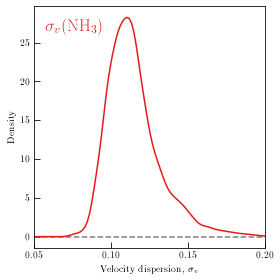

In [15]:
xrange = np.array([0.05, 0.2])
NH3_dv = fits.getdata(file_NH3_dv)
NH3_edv = fits.getdata(file_NH3_edv)
gd = np.isfinite(NH3_dv)
wt = 1 / NH3_dv[gd]**2
#
kde_dv = stats.gaussian_kde(NH3_dv[gd], weights=wt)
x_sample = np.linspace(xrange[0], xrange[1], num=100)
dv_sample = np.reshape(kde_dv(x_sample).T, x_sample.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, dv_sample, color=color_kde[0], label=r'$\sigma_v$')
#
ax.text(0.05, 0.9,  r'$\sigma_v$(NH$_3$)', color=color_kde[0],
        transform=ax.transAxes, size=17, weight=60)
ax.set_xlabel(r"Velocity dispersion, $\sigma_{v}$")
ax.set_ylabel(r"Density")
ax.set_xlim(xrange)

ax.set_xticks([0.05, 0.1, 0.15, 0.2])
# ax.set_yticks([0, 0.1, 0.2, 0.3])
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)
plt.tight_layout()                                                      
fig.savefig('figs/H-MM1_NH3_dv_KDE.pdf', dpi=100)

## Kinetic Temperature vs Column Density

In [16]:
range_N11 = [1.2, 11.5]
range_H2 = [0.0, 7]

tk = fits.getdata(file_NH3_Tkin)

N_H2_22 = N_H2*1e-22
N_NH3_14 = 10**(NH3_Ncol-14)

gd_Tk_H2 = np.isfinite(N_H2_22 * tk)

In [17]:
np.min(tk[gd_Tk_H2]), np.max(tk[gd_Tk_H2])

(8.185523014473, 17.105335801952823)

In [18]:
# First binning on Tk vs N(NH3)
gd_spec_Tk_NH3 = np.isfinite(NH3_Ncol_lin * tk)
bin_means_Tk_NH3, bin_edges_Tk_NH3, binnumber_Tk_NH3 = stats.binned_statistic(
    NH3_Ncol_lin[gd_spec_Tk_NH3], tk[gd_spec_Tk_NH3], 
    statistic='mean', bins=15)#, range=range_N11)

bin_ctr_Tk_NH3 = 0.5 * (bin_edges_Tk_NH3[1:] + bin_edges_Tk_NH3[:-1])

# Now binning on Tk vs H2
bin_means_Tk_H2, bin_edges_Tk_H2, binnumber_Tk_H2 = stats.binned_statistic(
    N_H2_22[gd_Tk_H2], tk[gd_Tk_H2],
    statistic='mean', bins=15)#, range=range_H2)

bin_ctr_Tk_H2 = 0.5 * (bin_edges_Tk_H2[1:] + bin_edges_Tk_H2[:-1])

xx_Tk_NH3, yy_Tk_NH3, Tk_NH3_kde = hmm1_kde(
    NH3_Ncol_lin[gd_spec_Tk_NH3], tk[gd_spec_Tk_NH3], 
    xmin=1.2, xmax=11.5, 
    ymin=8, ymax=18.0, 
    get_XY=True)

xx_Tk_H2, yy_Tk_H2, Tk_H2_kde = hmm1_kde(
    N_H2_22[gd_Tk_H2], tk[gd_Tk_H2], 
    xmin=0, xmax=6.5, 
    ymin=8, ymax=18.0, 
    get_XY=True)

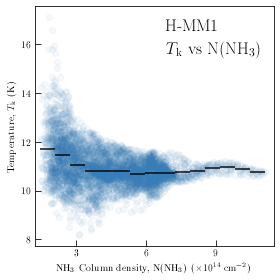

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(NH3_Ncol_lin, tk, alpha=0.05, color=color_kde[1])#, facecolors='blue', edgecolors='gray')
# binned values
ax.hlines(bin_means_Tk_NH3, bin_edges_Tk_NH3[:-1], bin_edges_Tk_NH3[1:], 
          colors='black', lw=2, alpha=0.7)
ax.set_xlim(range_N11)

ax.set_xlabel(r"NH$_3$ Column density, N(NH$_3$) ($\times 10^{14}$ cm$^{-2}$)")
ax.set_ylabel(r"Temperature, $T_{\rm k}$ (K)")
#
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'$T_{\rm k}$ vs N(NH$_3$)', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.set_xticks([3, 6, 9])
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Tk_Ncol.pdf', dpi=100)

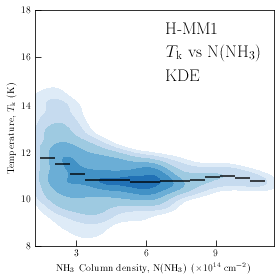

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
levels = levels_norm * Tk_NH3_kde.max()
cfset = ax.contourf(xx_Tk_NH3, yy_Tk_NH3, Tk_NH3_kde, colors=color_levels2, zorder=2,
                    levels=levels_norm_l * Tk_NH3_kde.max())

# binned values
ax.hlines(bin_means_Tk_NH3, bin_edges_Tk_NH3[:-1], bin_edges_Tk_NH3[1:], 
          colors='black', lw=2, alpha=0.7)
ax.set_xlim(range_N11)

ax.set_xlabel(r"NH$_3$ Column density, N(NH$_3$) ($\times 10^{14}$ cm$^{-2}$)")
ax.set_ylabel(r"Temperature, $T_{\rm k}$ (K)")
#
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'$T_{\rm k}$ vs N(NH$_3$)', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.7,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.set_xticks([3, 6, 9])
plt.tight_layout()                                                      
#
fig.savefig('figs/H-MM1_NH3_Tk_Ncol_KDE.pdf', dpi=100)

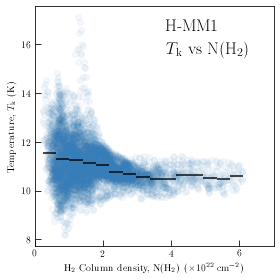

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(N_H2_22[gd_Tk_H2], tk[gd_Tk_H2], alpha=0.05, color=color_kde[1])#, facecolors='blue', edgecolors='gray')
# binned values
ax.hlines(bin_means_Tk_H2, bin_edges_Tk_H2[:-1], bin_edges_Tk_H2[1:], 
          colors='black', lw=2, alpha=0.7)
ax.set_xlim(range_H2)

ax.set_xlabel(r"H$_2$ Column density, N(H$_2$) ($\times 10^{22}$ cm$^{-2}$)")
ax.set_ylabel(r"Temperature, $T_{\rm k}$ (K)")
#
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'$T_{\rm k}$ vs N(H$_2$)', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.set_xticks([0, 2, 4, 6])
plt.tight_layout()
#
fig.savefig('figs/H-MM1_NH3_Tk_H2.pdf', dpi=100)

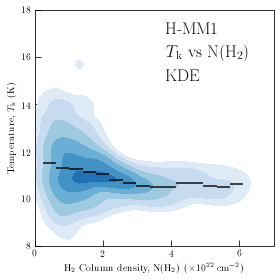

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * Tk_H2_kde.max()
cfset = ax.contourf(xx_Tk_H2, yy_Tk_H2, Tk_H2_kde, colors=color_levels2, zorder=2,
                    levels=levels_norm_l * Tk_H2_kde.max())
# binned values
ax.hlines(bin_means_Tk_H2, bin_edges_Tk_H2[:-1], bin_edges_Tk_H2[1:], 
          colors='black', lw=2, alpha=0.7)
ax.set_xlim(range_H2)

ax.set_xlabel(r"H$_2$ Column density, N(H$_2$) ($\times 10^{22}$ cm$^{-2}$)")
ax.set_ylabel(r"Temperature, $T_{\rm k}$ (K)")
#
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)

ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'$T_{\rm k}$ vs N(H$_2$)', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.7,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.set_xticks([0, 2, 4, 6])
plt.tight_layout()
#
fig.savefig('figs/H-MM1_NH3_Tk_H2_KDE.pdf', dpi=100)

## Abundances with respect to H$_2$
Calculation of the NH$_3$ and o-NH$_2$D abundance with respect of the H$_2$ column density derived with Spitzer

In [23]:
NH3_H2 = 10**NH3_Ncol/N_H2 * 1e8

# abundances in units of 10^-8
hdu_NH3_H2_regrid = fits.PrimaryHDU(NH3_H2, hd)

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.8/site-packages/aplpy/core.py:780: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/gm/ncfmlqkd1vs3h4mb9b645l4m0000gn/T/ipykernel_58822/2029998527.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


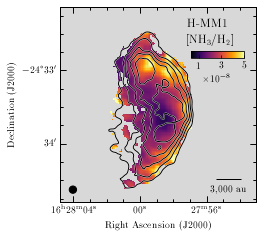

In [24]:
text_color = 'black'
fig = aplpy.FITSFigure(hdu_NH3_H2_regrid, figsize=(4, 4))
#
fig.show_colorscale(vmin=0.3, vmax=5, cmap='inferno', interpolation='None')
plot_setup_vla(fig, label_col=text_color)
#
fig.add_label(xpos_lab1, ypos_lab1, 'H-MM1', relative=True, 
                horizontalalignment='left', color=text_color, size=12)
fig.add_label(xpos_lab2, ypos_lab2, r'[NH$_3$/H$_2$]', relative=True, 
                horizontalalignment='left', color=text_color, size=12)

fig.add_colorbar()
fig.colorbar.set_box(col_pos, 'horizontal')
fig.colorbar.set_ticks([1, 3, 5])
fig.colorbar.set_axis_label_text(r'$\times10^{-8}$')
plt.tight_layout()
#
fig.savefig('figs/H-MM1_NH3_H2_ratio.pdf', dpi=200)

<[o-NH2D/H2]> = 2.7


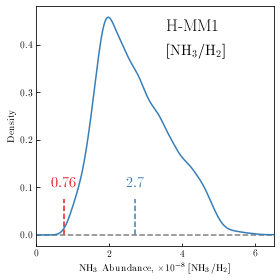

In [25]:
X_NH3_H2 = NH3_H2 # NH3_H2 = 10**NH3_Ncol/N_H2 * 1e8
gd_X_NH3_H2 =  np.isfinite(X_NH3_H2)
X_NH3_H2_mean = np.round(np.mean(X_NH3_H2[gd_X_NH3_H2]), decimals=2)
print('<[o-NH2D/H2]> = {0}'.format(X_NH3_H2_mean))

xrange = np.array([0., 7.0])

kde_NH3_H2 = stats.gaussian_kde(X_NH3_H2[gd_X_NH3_H2])

x_sample = np.linspace(xrange[0], xrange[1], num=500)
X_NH3_H2_sample = np.reshape(kde_NH3_H2(x_sample).T, x_sample.shape)

#########
### NH3/H2
#########
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, X_NH3_H2_sample, color=color_kde[1], label=r'$\sigma_v$')
#
ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'[NH$_3$/H$_2$]', color='black', 
        transform=ax.transAxes, size=15, weight=60)

ax.set_xlabel(r"NH$_3$ Abundance, $\times 10^{-8}$ [NH$_3$/H$_2$]")
ax.set_ylabel(r"Density")
ax.set_xlim([0.0, 6.5])

# add vertical markers with mean values, plus text
ax.vlines(3.8*2/10., ymin=0, ymax=0.075, color=color_kde[0], linestyle='--')
ax.text(3.8*2/10, 0.1, 2*3.8/10 , color=color_kde[0], horizontalalignment='center', size=15, weight=60)

# add vertical markers with mean values, plus text
ax.vlines(X_NH3_H2_mean, ymin=0, ymax=0.075, color=color_kde[1], linestyle='--')
ax.text(X_NH3_H2_mean, 0.1, X_NH3_H2_mean , color=color_kde[1], horizontalalignment='center', size=15, weight=60)


ax.set_xticks([0., 2, 4, 6])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
# ax.set_yticks([0, 0.015, 0.030, 0.045])
plt.tight_layout()
fig.savefig('figs/H-MM1_X_NH3_H2_kde.pdf', dpi=100)

In [26]:
range_H2 = [0.0, 7]
N_H2_22 = N_H2*1e-22
N_NH3_14 = 10**(NH3_Ncol-14)

gd_X_NH3 = np.isfinite(N_H2_22 * N_NH3_14)

bin_means_X_NH3, bin_edges_X_NH3, binnumber_X_NH3 = stats.binned_statistic(
    N_H2_22[gd_X_NH3], 
    N_NH3_14[gd_X_NH3],
    statistic='mean', bins=15)#, range=range_H2)

bin_ctr_X_NH3 = 0.5 * (bin_edges_X_NH3[1:] + bin_edges_X_NH3[:-1])


xx, yy, NH3_H2_kde = hmm1_kde(N_H2_22[gd_X_NH3], N_NH3_14[gd_X_NH3], 
                              xmin=0, xmax=6.5, 
                              ymin=1, ymax=11.3, 
                              get_XY=True)

In [27]:
gd_X_NH3_cut = np.isfinite(N_H2_22 * N_NH3_14) * (N_H2_22 < 3.)
res_X_NH3_cut = stats.linregress(N_H2_22[gd_X_NH3_cut], N_NH3_14[gd_X_NH3_cut])
print(res_X_NH3_cut)

LinregressResult(slope=2.0375777286584937, intercept=1.0430127947717165, rvalue=0.7367513089282619, pvalue=0.0, stderr=0.028644317169137224, intercept_stderr=0.048497120752448934)


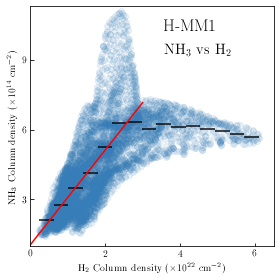

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))
# data points
ax.scatter(N_H2_22[gd_X_NH3], N_NH3_14[gd_X_NH3], alpha=0.1, color=color_kde[1])
# binned values
ax.hlines(bin_means_X_NH3, bin_edges_X_NH3[:-1], bin_edges_X_NH3[1:], 
          colors='black', lw=2, alpha=0.7)

ax.set_xlim([0, 6.5])
ax.set_ylim([1, 11.3])

ax.set_xlabel(r"H$_2$ Column density ($\times 10^{22}$ cm$^{-2}$)")
ax.set_ylabel(r"NH$_3$ Column density ($\times 10^{14}$ cm$^{-2}$)")
ax.set_xticks([0, 2, 4, 6])
ax.set_yticks([3, 6, 9])
ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'NH$_3$ vs H$_2$', color='black', 
        transform=ax.transAxes, size=15, weight=60)

x_sample = np.array([0, 3.0])
ax.plot(x_sample, x_sample*res_X_NH3_cut.slope + res_X_NH3_cut.intercept, color='red')

ax.set_aspect('auto')
plt.tight_layout()
fig.savefig('figs/H-MM1_NH3_v_H2.pdf')

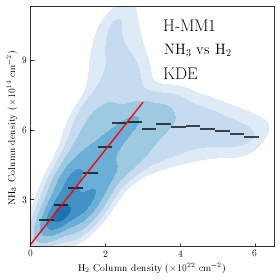

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * NH3_H2_kde.max()
cfset = ax.contourf(xx, yy, NH3_H2_kde, colors=color_levels2, zorder=2,
                    levels=levels_norm_l * NH3_H2_kde.max())

ax.set_xlabel(r"H$_2$ Column density ($\times 10^{22}$ cm$^{-2}$)")
ax.set_ylabel(r"NH$_3$ Column density ($\times 10^{14}$ cm$^{-2}$)")

ax.text(0.55, 0.9,  r'H-MM1', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.8,  r'NH$_3$ vs H$_2$', color='black', 
        transform=ax.transAxes, size=15, weight=60)
ax.text(0.55, 0.7,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)

x_sample = np.array([0, 3.0])
ax.plot(x_sample, x_sample*res_X_NH3_cut.slope + res_X_NH3_cut.intercept, color='red')

ax.set_xticks([0, 2, 4, 6])
ax.set_yticks([3, 6, 9])
ax.set_xlim([0, 6.5])
ax.set_ylim([1, 11.3])
ax.set_aspect('auto')

ax.hlines(bin_means_X_NH3, bin_edges_X_NH3[:-1], bin_edges_X_NH3[1:], 
          colors='black', lw=2, alpha=0.7)#, label='binned statistic of data')
plt.tight_layout()
fig.savefig('figs/H-MM1_NH3_v_H2_KDE.pdf')

In [30]:
res_X_NH3_cut.slope, res_X_NH3_cut.stderr, res_X_NH3_cut.intercept, res_X_NH3_cut.intercept_stderr

(2.0375777286584937,
 0.028644317169137224,
 1.0430127947717165,
 0.048497120752448934)